##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention


The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-08 06:31:47.983845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 06:31:48.025626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 06:31:48.026400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [4]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
    annotation_file = 'annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [5]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [6]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.

# train_image_paths = image_paths[:6000]
train_image_paths = image_paths
print(len(train_image_paths))

82783


In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A table topped with a plate of sandwiches and a cup of coffee. <end>


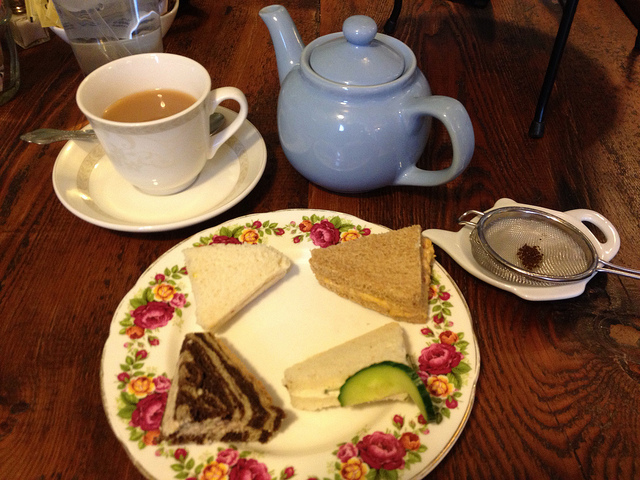

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2022-05-08 06:31:49.733994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 06:31:49.734507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 06:31:49.735340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 06:31:49.736088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

In [12]:
# from tqdm import tqdm

# # Get unique images
# encode_train = sorted(set(img_name_vector))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [13]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)


In [14]:
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [15]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [17]:
token_vocab = tokenizer.get_vocabulary()
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=token_vocab)
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=token_vocab,
    invert=True)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(331298, 331298, 82815, 82815)

In [20]:
with open('img_name_train.pickle', 'wb') as f:
    pickle.dump(img_name_train, f)
with open('cap_train.pickle', 'wb') as f:
    pickle.dump(cap_train, f)
with open('img_name_val.pickle', 'wb') as f:
    pickle.dump(img_name_val, f)
with open('cap_val.pickle', 'wb') as f:
    pickle.dump(cap_val, f)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [21]:
# with open('img_name_train.pickle', 'rb') as f:
#     img_name_train = pickle.load(f)
# with open('cap_train.pickle', 'rb') as f:
#     cap_train = pickle.load(f)
# with open('img_name_val.pickle', 'rb') as f:
#     img_name_val = pickle.load(f)
# with open('cap_val.pickle', 'rb') as f:
#     cap_val = pickle.load(f)

In [42]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
v_num_steps = len(img_name_val) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [43]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

The decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [46]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [47]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [48]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # print(self.lstm(x))    
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [49]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [50]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [51]:
checkpoint_path = "./n_checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [53]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot = []

In [54]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [55]:
@tf.function
def val_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [56]:
EPOCHS = 30
best_val_loss = 0.


for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    v_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # break
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
        v_total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Validation Loss {average_batch_loss:.4f}')
        break
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_loss_plot.append(v_total_loss / num_steps)
    
    if val_loss_plot[-1] < best_val_loss:
        best_val_loss = val_loss_plot[-1]
        ckpt_manager.save()
        print("Saved the better model")
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        print("Saved the epoch multiple of 5")

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Epoch {epoch+1} Validation Loss {v_total_loss/v_num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9018
Epoch 1 Batch 100 Loss 1.1292
Epoch 1 Batch 200 Loss 0.9749
Epoch 1 Batch 300 Loss 0.8533
Epoch 1 Batch 400 Loss 0.8195
Epoch 1 Batch 500 Loss 0.8102
Epoch 1 Batch 600 Loss 0.7576
Epoch 1 Batch 700 Loss 0.7250
Epoch 1 Batch 800 Loss 0.7618
Epoch 1 Batch 900 Loss 0.7860
Epoch 1 Batch 1000 Loss 0.7265
Epoch 1 Batch 1100 Loss 0.6986
Epoch 1 Batch 1200 Loss 0.6470
Epoch 1 Batch 1300 Loss 0.6840
Epoch 1 Batch 1400 Loss 0.7465
Epoch 1 Batch 1500 Loss 0.6708
Epoch 1 Batch 1600 Loss 0.6873
Epoch 1 Batch 1700 Loss 0.6717
Epoch 1 Batch 1800 Loss 0.6460
Epoch 1 Batch 1900 Loss 0.7481
Epoch 1 Batch 2000 Loss 0.6872
Epoch 1 Batch 2100 Loss 0.7231
Epoch 1 Batch 2200 Loss 0.7032
Epoch 1 Batch 2300 Loss 0.6178
Epoch 1 Batch 2400 Loss 0.6814
Epoch 1 Batch 2500 Loss 0.6552
Epoch 1 Batch 2600 Loss 0.6653
Epoch 1 Batch 2700 Loss 0.5991
Epoch 1 Batch 2800 Loss 0.6705
Epoch 1 Batch 2900 Loss 0.7322
Epoch 1 Batch 3000 Loss 0.6061
Epoch 1 Batch 3100 Loss 0.6645
Epoch 1 Batch 3200 L

2022-05-08 08:05:51.911759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 971 of 1000
2022-05-08 08:05:52.135001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 1 Batch 0 Validation Loss 0.6526
Epoch 1 Batch 100 Validation Loss 0.6901
Epoch 1 Batch 200 Validation Loss 0.6668
Epoch 1 Batch 300 Validation Loss 0.6738
Epoch 1 Batch 400 Validation Loss 0.6793
Epoch 1 Batch 500 Validation Loss 0.6798
Epoch 1 Batch 600 Validation Loss 0.6619
Epoch 1 Batch 700 Validation Loss 0.6807
Epoch 1 Batch 800 Validation Loss 0.7061
Epoch 1 Batch 900 Validation Loss 0.6086
Epoch 1 Batch 1000 Validation Loss 0.6081
Epoch 1 Batch 1100 Validation Loss 0.6493
Epoch 1 Batch 1200 Validation Loss 0.6058
Epoch 1 Loss 0.699992
Epoch 1 Validation Loss 0.648844
Time taken for 1 epoch 3932.52 sec



2022-05-08 08:19:43.087399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 976 of 1000
2022-05-08 08:19:43.278299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 2 Batch 0 Loss 0.6205
Epoch 2 Batch 100 Loss 0.6543
Epoch 2 Batch 200 Loss 0.6270
Epoch 2 Batch 300 Loss 0.6592
Epoch 2 Batch 400 Loss 0.6453
Epoch 2 Batch 500 Loss 0.6353
Epoch 2 Batch 600 Loss 0.5985
Epoch 2 Batch 700 Loss 0.6266
Epoch 2 Batch 800 Loss 0.6001
Epoch 2 Batch 900 Loss 0.6042
Epoch 2 Batch 1000 Loss 0.6092
Epoch 2 Batch 1100 Loss 0.6017
Epoch 2 Batch 1200 Loss 0.5379
Epoch 2 Batch 1300 Loss 0.5834
Epoch 2 Batch 1400 Loss 0.5486
Epoch 2 Batch 1500 Loss 0.6083
Epoch 2 Batch 1600 Loss 0.6416
Epoch 2 Batch 1700 Loss 0.5612
Epoch 2 Batch 1800 Loss 0.5879
Epoch 2 Batch 1900 Loss 0.6990
Epoch 2 Batch 2000 Loss 0.6135
Epoch 2 Batch 2100 Loss 0.6482
Epoch 2 Batch 2200 Loss 0.6301
Epoch 2 Batch 2300 Loss 0.6294
Epoch 2 Batch 2400 Loss 0.6544
Epoch 2 Batch 2500 Loss 0.6511
Epoch 2 Batch 2600 Loss 0.6137
Epoch 2 Batch 2700 Loss 0.5755
Epoch 2 Batch 2800 Loss 0.5982
Epoch 2 Batch 2900 Loss 0.5993
Epoch 2 Batch 3000 Loss 0.6053
Epoch 2 Batch 3100 Loss 0.6408
Epoch 2 Batch 3200 L

2022-05-08 09:16:40.867713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 901 of 1000
2022-05-08 09:16:41.887930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 2 Batch 0 Validation Loss 0.6163
Epoch 2 Batch 100 Validation Loss 0.5997
Epoch 2 Batch 200 Validation Loss 0.5912
Epoch 2 Batch 300 Validation Loss 0.6062
Epoch 2 Batch 400 Validation Loss 0.6061
Epoch 2 Batch 500 Validation Loss 0.5963
Epoch 2 Batch 600 Validation Loss 0.6336
Epoch 2 Batch 700 Validation Loss 0.6482
Epoch 2 Batch 800 Validation Loss 0.5827
Epoch 2 Batch 900 Validation Loss 0.5894
Epoch 2 Batch 1000 Validation Loss 0.6264
Epoch 2 Batch 1100 Validation Loss 0.6556
Epoch 2 Batch 1200 Validation Loss 0.6744
Epoch 2 Loss 0.613499
Epoch 2 Validation Loss 0.627565
Time taken for 1 epoch 4288.90 sec



2022-05-08 09:31:12.996447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 876 of 1000
2022-05-08 09:31:14.237237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 3 Batch 0 Loss 0.6202
Epoch 3 Batch 100 Loss 0.5923
Epoch 3 Batch 200 Loss 0.5521
Epoch 3 Batch 300 Loss 0.5319
Epoch 3 Batch 400 Loss 0.6192
Epoch 3 Batch 500 Loss 0.5423
Epoch 3 Batch 600 Loss 0.6248
Epoch 3 Batch 700 Loss 0.6236
Epoch 3 Batch 800 Loss 0.6724
Epoch 3 Batch 900 Loss 0.6049
Epoch 3 Batch 1000 Loss 0.6659
Epoch 3 Batch 1100 Loss 0.6199
Epoch 3 Batch 1200 Loss 0.6387
Epoch 3 Batch 1300 Loss 0.6586
Epoch 3 Batch 1400 Loss 0.6289
Epoch 3 Batch 1500 Loss 0.6254
Epoch 3 Batch 1600 Loss 0.6406
Epoch 3 Batch 1700 Loss 0.5460
Epoch 3 Batch 1800 Loss 0.6054
Epoch 3 Batch 1900 Loss 0.6221
Epoch 3 Batch 2000 Loss 0.5591
Epoch 3 Batch 2100 Loss 0.5938
Epoch 3 Batch 2200 Loss 0.5968
Epoch 3 Batch 2300 Loss 0.5819
Epoch 3 Batch 2400 Loss 0.6128
Epoch 3 Batch 2500 Loss 0.5840
Epoch 3 Batch 2600 Loss 0.6440
Epoch 3 Batch 2700 Loss 0.5416
Epoch 3 Batch 2800 Loss 0.5664
Epoch 3 Batch 2900 Loss 0.5773
Epoch 3 Batch 3000 Loss 0.6171
Epoch 3 Batch 3100 Loss 0.5894
Epoch 3 Batch 3200 L

2022-05-08 10:29:11.388774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 936 of 1000
2022-05-08 10:29:12.057170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 3 Batch 0 Validation Loss 0.6011
Epoch 3 Batch 100 Validation Loss 0.5874
Epoch 3 Batch 200 Validation Loss 0.6414
Epoch 3 Batch 300 Validation Loss 0.5707
Epoch 3 Batch 400 Validation Loss 0.6591
Epoch 3 Batch 500 Validation Loss 0.6285
Epoch 3 Batch 600 Validation Loss 0.5976
Epoch 3 Batch 700 Validation Loss 0.5938
Epoch 3 Batch 800 Validation Loss 0.6603
Epoch 3 Batch 900 Validation Loss 0.5599
Epoch 3 Batch 1000 Validation Loss 0.6036
Epoch 3 Batch 1100 Validation Loss 0.6031
Epoch 3 Batch 1200 Validation Loss 0.5886
Epoch 3 Loss 0.588196
Epoch 3 Validation Loss 0.621699
Time taken for 1 epoch 4358.10 sec



2022-05-08 10:43:51.118173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 911 of 1000
2022-05-08 10:43:52.144287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 4 Batch 0 Loss 0.5752
Epoch 4 Batch 100 Loss 0.5688
Epoch 4 Batch 200 Loss 0.5512
Epoch 4 Batch 300 Loss 0.5638
Epoch 4 Batch 400 Loss 0.6030
Epoch 4 Batch 500 Loss 0.5714
Epoch 4 Batch 600 Loss 0.5808
Epoch 4 Batch 700 Loss 0.5664
Epoch 4 Batch 800 Loss 0.6024
Epoch 4 Batch 900 Loss 0.5353
Epoch 4 Batch 1000 Loss 0.5409
Epoch 4 Batch 1100 Loss 0.6235
Epoch 4 Batch 1200 Loss 0.5931
Epoch 4 Batch 1300 Loss 0.5590
Epoch 4 Batch 1400 Loss 0.5778
Epoch 4 Batch 1500 Loss 0.5352
Epoch 4 Batch 1600 Loss 0.5763
Epoch 4 Batch 1700 Loss 0.6317
Epoch 4 Batch 1800 Loss 0.5367
Epoch 4 Batch 1900 Loss 0.5397
Epoch 4 Batch 2000 Loss 0.5617
Epoch 4 Batch 2100 Loss 0.5822
Epoch 4 Batch 2200 Loss 0.5899
Epoch 4 Batch 2300 Loss 0.6022
Epoch 4 Batch 2400 Loss 0.5914
Epoch 4 Batch 2500 Loss 0.5590
Epoch 4 Batch 2600 Loss 0.6381
Epoch 4 Batch 2700 Loss 0.5275
Epoch 4 Batch 2800 Loss 0.5848
Epoch 4 Batch 2900 Loss 0.5626
Epoch 4 Batch 3000 Loss 0.5500
Epoch 4 Batch 3100 Loss 0.5474
Epoch 4 Batch 3200 L

2022-05-08 11:45:53.000251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 721 of 1000
2022-05-08 11:45:56.399079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 4 Batch 0 Validation Loss 0.5420
Epoch 4 Batch 100 Validation Loss 0.5820
Epoch 4 Batch 200 Validation Loss 0.6098
Epoch 4 Batch 300 Validation Loss 0.6080
Epoch 4 Batch 400 Validation Loss 0.6258
Epoch 4 Batch 500 Validation Loss 0.6317
Epoch 4 Batch 600 Validation Loss 0.5852
Epoch 4 Batch 700 Validation Loss 0.6189
Epoch 4 Batch 800 Validation Loss 0.5518
Epoch 4 Batch 900 Validation Loss 0.6719
Epoch 4 Batch 1000 Validation Loss 0.6417
Epoch 4 Batch 1100 Validation Loss 0.6964
Epoch 4 Batch 1200 Validation Loss 0.6420
Epoch 4 Loss 0.572079
Epoch 4 Validation Loss 0.618850
Time taken for 1 epoch 4659.93 sec



2022-05-08 12:01:31.015378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 866 of 1000
2022-05-08 12:01:32.514196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 5 Batch 0 Loss 0.5386
Epoch 5 Batch 100 Loss 0.6186
Epoch 5 Batch 200 Loss 0.5382
Epoch 5 Batch 300 Loss 0.5397
Epoch 5 Batch 400 Loss 0.5568
Epoch 5 Batch 500 Loss 0.5671
Epoch 5 Batch 600 Loss 0.5724
Epoch 5 Batch 700 Loss 0.5899
Epoch 5 Batch 800 Loss 0.6120
Epoch 5 Batch 900 Loss 0.5506
Epoch 5 Batch 1000 Loss 0.5667
Epoch 5 Batch 1100 Loss 0.5971
Epoch 5 Batch 1200 Loss 0.5966
Epoch 5 Batch 1300 Loss 0.4798
Epoch 5 Batch 1400 Loss 0.5775
Epoch 5 Batch 1500 Loss 0.5898
Epoch 5 Batch 1600 Loss 0.5451
Epoch 5 Batch 1700 Loss 0.5383
Epoch 5 Batch 1800 Loss 0.6235
Epoch 5 Batch 1900 Loss 0.6604
Epoch 5 Batch 2000 Loss 0.4915
Epoch 5 Batch 2100 Loss 0.5031
Epoch 5 Batch 2200 Loss 0.5799
Epoch 5 Batch 2300 Loss 0.5337
Epoch 5 Batch 2400 Loss 0.5614
Epoch 5 Batch 2500 Loss 0.5840
Epoch 5 Batch 2600 Loss 0.5892
Epoch 5 Batch 2700 Loss 0.5311
Epoch 5 Batch 2800 Loss 0.5693
Epoch 5 Batch 2900 Loss 0.5177
Epoch 5 Batch 3000 Loss 0.5446
Epoch 5 Batch 3100 Loss 0.5983
Epoch 5 Batch 3200 L

2022-05-08 13:00:46.914181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 921 of 1000
2022-05-08 13:00:47.754874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 5 Batch 0 Validation Loss 0.6005
Epoch 5 Batch 100 Validation Loss 0.6191
Epoch 5 Batch 200 Validation Loss 0.6459
Epoch 5 Batch 300 Validation Loss 0.6048
Epoch 5 Batch 400 Validation Loss 0.6463
Epoch 5 Batch 500 Validation Loss 0.7376
Epoch 5 Batch 600 Validation Loss 0.6074
Epoch 5 Batch 700 Validation Loss 0.5857
Epoch 5 Batch 800 Validation Loss 0.5743
Epoch 5 Batch 900 Validation Loss 0.6746
Epoch 5 Batch 1000 Validation Loss 0.6216
Epoch 5 Batch 1100 Validation Loss 0.6131
Epoch 5 Batch 1200 Validation Loss 0.6379
Epoch 5 Loss 0.558502
Epoch 5 Validation Loss 0.621039
Time taken for 1 epoch 4442.56 sec



2022-05-08 13:15:33.576669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 946 of 1000
2022-05-08 13:15:34.184025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 6 Batch 0 Loss 0.5312
Epoch 6 Batch 100 Loss 0.5151
Epoch 6 Batch 200 Loss 0.4853
Epoch 6 Batch 300 Loss 0.5959
Epoch 6 Batch 400 Loss 0.5288
Epoch 6 Batch 500 Loss 0.5083
Epoch 6 Batch 600 Loss 0.5225
Epoch 6 Batch 700 Loss 0.5520
Epoch 6 Batch 800 Loss 0.5669
Epoch 6 Batch 900 Loss 0.5578
Epoch 6 Batch 1000 Loss 0.5329
Epoch 6 Batch 1100 Loss 0.5505
Epoch 6 Batch 1200 Loss 0.5649
Epoch 6 Batch 1300 Loss 0.4962
Epoch 6 Batch 1400 Loss 0.5468
Epoch 6 Batch 1500 Loss 0.5106
Epoch 6 Batch 1600 Loss 0.6092
Epoch 6 Batch 1700 Loss 0.5646
Epoch 6 Batch 1800 Loss 0.5471
Epoch 6 Batch 1900 Loss 0.5112
Epoch 6 Batch 2000 Loss 0.5345
Epoch 6 Batch 2100 Loss 0.5518
Epoch 6 Batch 2200 Loss 0.4894
Epoch 6 Batch 2300 Loss 0.5724
Epoch 6 Batch 2400 Loss 0.5473
Epoch 6 Batch 2500 Loss 0.5740
Epoch 6 Batch 2600 Loss 0.5741
Epoch 6 Batch 2700 Loss 0.6055
Epoch 6 Batch 2800 Loss 0.5807
Epoch 6 Batch 2900 Loss 0.5763
Epoch 6 Batch 3000 Loss 0.5268
Epoch 6 Batch 3100 Loss 0.5275
Epoch 6 Batch 3200 L

2022-05-08 14:13:51.838898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 941 of 1000
2022-05-08 14:13:52.399391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 6 Batch 0 Validation Loss 0.6410
Epoch 6 Batch 100 Validation Loss 0.5991
Epoch 6 Batch 200 Validation Loss 0.5414
Epoch 6 Batch 300 Validation Loss 0.7306
Epoch 6 Batch 400 Validation Loss 0.6515
Epoch 6 Batch 500 Validation Loss 0.5962
Epoch 6 Batch 600 Validation Loss 0.6328
Epoch 6 Batch 700 Validation Loss 0.5396
Epoch 6 Batch 800 Validation Loss 0.5873
Epoch 6 Batch 900 Validation Loss 0.6505
Epoch 6 Batch 1000 Validation Loss 0.6739
Epoch 6 Batch 1100 Validation Loss 0.6217
Epoch 6 Batch 1200 Validation Loss 0.6263
Epoch 6 Loss 0.546971
Epoch 6 Validation Loss 0.623130
Time taken for 1 epoch 4365.11 sec



2022-05-08 14:28:18.524500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 976 of 1000
2022-05-08 14:28:18.686816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


Epoch 7 Batch 0 Loss 0.5356
Epoch 7 Batch 100 Loss 0.5491


KeyboardInterrupt: 

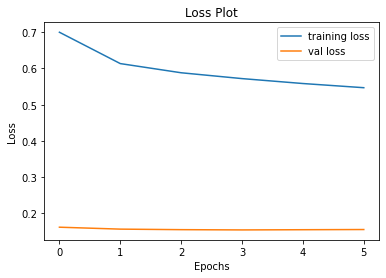

In [57]:
plt.plot(loss_plot, label = 'training loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()
# print(loss_plot)

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [58]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [59]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> two guys playing soccer with a group of onlookers behind them. <end>
Prediction Caption: two teams playing a competitive frisbee on a soccer field playing frisbee in a green park. <end>


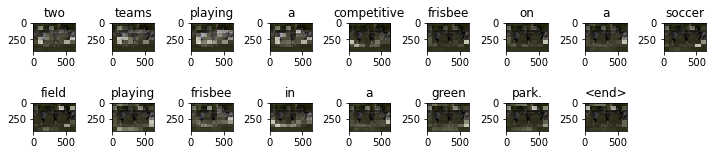

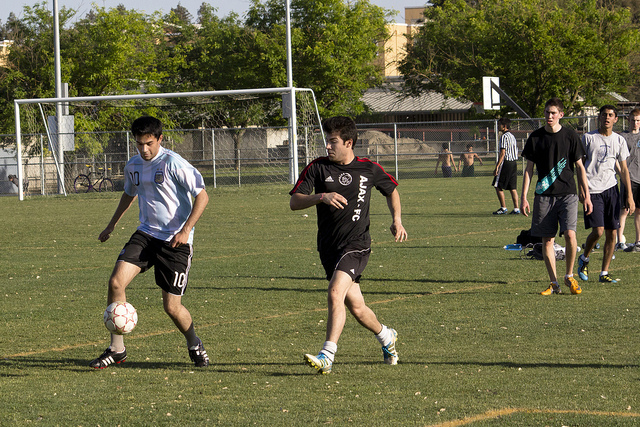

In [62]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


/home/jupyter/.keras/datasets/image.jpg
Prediction Caption: a surfer sits on a wave in the ocean <end>


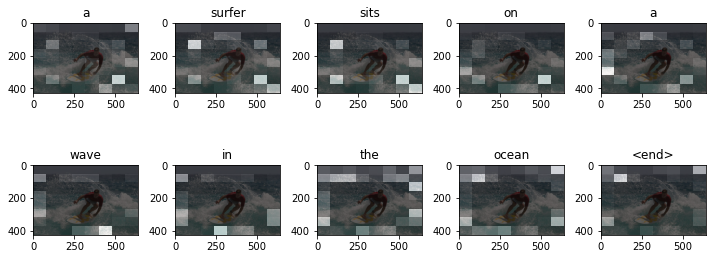

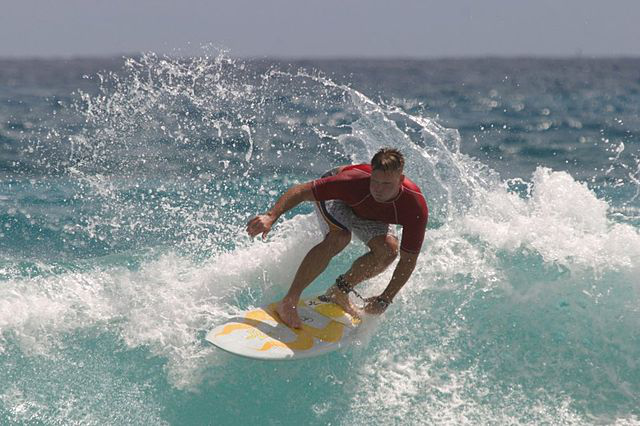

In [63]:
# del image_url
image_url = 'https://images.forbes.com/media/2016/03/28/0328_ny-yankees-alex-rodriguez_650x455.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)